In [144]:
#https://www.kaggle.com/code/rehabahmedkhalifa/credit-classification

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import linregress
import seaborn as sns




In [145]:
#Import raw data
df=pd.read_csv("credit_train.csv" ,sep="," ,encoding="utf-8")
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100514 entries, 0 to 100513
Data columns (total 19 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   Loan ID                       100000 non-null  object 
 1   Customer ID                   100000 non-null  object 
 2   Loan Status                   100000 non-null  object 
 3   Current Loan Amount           100000 non-null  float64
 4   Term                          100000 non-null  object 
 5   Credit Score                  80846 non-null   float64
 6   Annual Income                 80846 non-null   float64
 7   Years in current job          95778 non-null   object 
 8   Home Ownership                100000 non-null  object 
 9   Purpose                       100000 non-null  object 
 10  Monthly Debt                  100000 non-null  float64
 11  Years of Credit History       100000 non-null  float64
 12  Months since last delinquent  46859 non-null

In [146]:
#Drop any rows that have blank values in the Credit Score or Annual Income columns
df = df.dropna(subset=['Credit Score', 'Annual Income'])

#Replace any blanks with zeros in the following columns
df['Months since last delinquent']=df['Months since last delinquent'].fillna(0)
df['Bankruptcies']=df['Bankruptcies'].fillna(0)
df['Tax Liens']=df['Tax Liens'].fillna(0)

#As the 'Loan ID' column should be unique, remove any rows with a duplicated loan ID
df = df.drop_duplicates(subset=['Loan ID'])

df['Credit Score'].value_counts().sort_index()

Credit Score
585.0      9
586.0      6
587.0      8
588.0     13
589.0      5
          ..
7470.0    51
7480.0    43
7490.0    23
7500.0    24
7510.0     9
Name: count, Length: 324, dtype: int64

In [147]:
#Value Counts of the Credit Score column shows some 4 digit credit scores where an extra 0 has been added to the end
#To remove the 4th digit of the credit score if present
df['Credit Score'] = df['Credit Score'].astype(int).apply(lambda x: x/10 if len(str(x)) == 4 else x)

#Convert the Credit Score column to int
df['Credit Score'] = df['Credit Score'].astype(float).astype(int)

#Ensure all credit scores are valid credit score values
df['Credit Score'].value_counts().sort_index()

Credit Score
585      11
586       7
587       8
588      13
589       6
       ... 
747    1876
748    1641
749     850
750    1258
751     732
Name: count, Length: 167, dtype: int64

In [148]:
#Create a Debt to Income Ratio column
df["Monthly Debt"] = df["Monthly Debt"].astype(int)
df["Annual Income"] = df["Annual Income"].astype(int)

df["Debt to Income Ratio"] = df["Monthly Debt"]/(df["Annual Income"]/12).astype(float)
df["Debt to Income Ratio"] = df["Debt to Income Ratio"].round(4)
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 67052 entries, 0 to 99999
Data columns (total 20 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Loan ID                       67052 non-null  object 
 1   Customer ID                   67052 non-null  object 
 2   Loan Status                   67052 non-null  object 
 3   Current Loan Amount           67052 non-null  float64
 4   Term                          67052 non-null  object 
 5   Credit Score                  67052 non-null  int32  
 6   Annual Income                 67052 non-null  int32  
 7   Years in current job          64196 non-null  object 
 8   Home Ownership                67052 non-null  object 
 9   Purpose                       67052 non-null  object 
 10  Monthly Debt                  67052 non-null  int32  
 11  Years of Credit History       67052 non-null  float64
 12  Months since last delinquent  67052 non-null  float64
 13  Number

In [149]:
# Exclude outliers from Annual Income
quartiles = df['Annual Income'].quantile([.25,.5,.75])
lowerq = quartiles[0.25]
upperq = quartiles[0.75]
iqr = upperq-lowerq

lower_bound = lowerq - (1.5*iqr)
upper_bound = upperq + (1.5*iqr)

df = df.loc[(df['Annual Income'] > lower_bound) & (df['Annual Income'] < upper_bound)]
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 63916 entries, 0 to 99999
Data columns (total 20 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Loan ID                       63916 non-null  object 
 1   Customer ID                   63916 non-null  object 
 2   Loan Status                   63916 non-null  object 
 3   Current Loan Amount           63916 non-null  float64
 4   Term                          63916 non-null  object 
 5   Credit Score                  63916 non-null  int32  
 6   Annual Income                 63916 non-null  int32  
 7   Years in current job          61082 non-null  object 
 8   Home Ownership                63916 non-null  object 
 9   Purpose                       63916 non-null  object 
 10  Monthly Debt                  63916 non-null  int32  
 11  Years of Credit History       63916 non-null  float64
 12  Months since last delinquent  63916 non-null  float64
 13  Number

In [150]:
#Identify the values in the Purpose column
df['Purpose'].value_counts()

Purpose
Debt Consolidation      50673
other                    3749
Home Improvements        3548
Other                    2056
Business Loan             910
Buy a Car                 849
Medical Bills             680
Buy House                 408
Take a Trip               350
major_purchase            231
small_business            177
moving                     89
wedding                    68
Educational Expenses       66
vacation                   57
renewable_energy            5
Name: count, dtype: int64

In [151]:
#Clean up the Purpose colmun and consolidate similar categories
df['Purpose'].replace({'small_business': 'Business Loan'}, inplace=True)
df['Purpose'].replace(['other','major_purchase','Educational Expenses',"moving",'renewable_energy','wedding'],'Other', inplace=True)
df['Purpose'].replace(['Take a Trip','vacation'],'Vacation', inplace=True)

df['Purpose'].value_counts()

Purpose
Debt Consolidation    50673
Other                  6264
Home Improvements      3548
Business Loan          1087
Buy a Car               849
Medical Bills           680
Buy House               408
Vacation                407
Name: count, dtype: int64

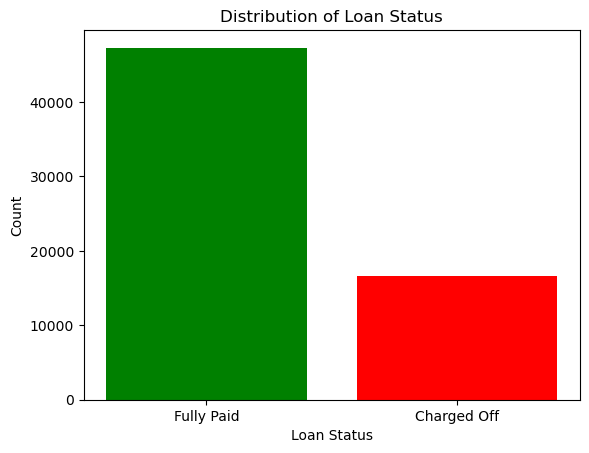

In [152]:
#Create a bar chart of the number of loans fully paid vs charged off
status_counts = df['Loan Status'].value_counts()
plt.bar(status_counts.index, status_counts.values, color=['green', 'red'])
plt.xlabel('Loan Status')
plt.ylabel('Count')
plt.title('Distribution of Loan Status')
plt.show()

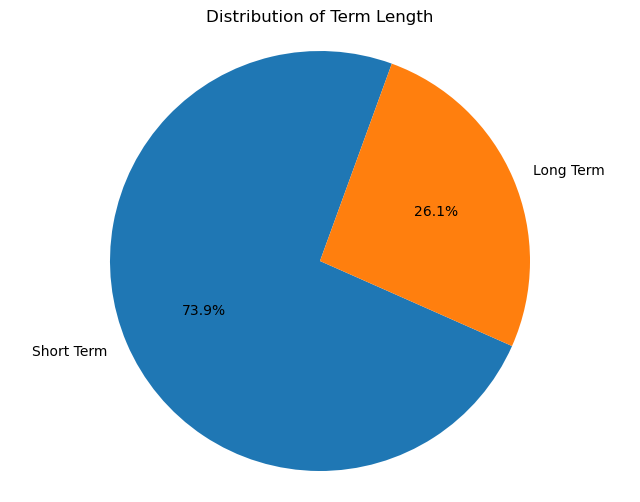

In [153]:
#Create a pie chart showing the breakdown of Short Term vs Long Term loans
term_counts = df['Term'].value_counts()

# Plotting the pie chart
plt.figure(figsize=(8, 6))  # Adjust the figure size if needed
plt.pie(term_counts, labels=term_counts.index, autopct='%1.1f%%', startangle=70)

# Adding title
plt.title('Distribution of Term Length')

# Show the plot
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()

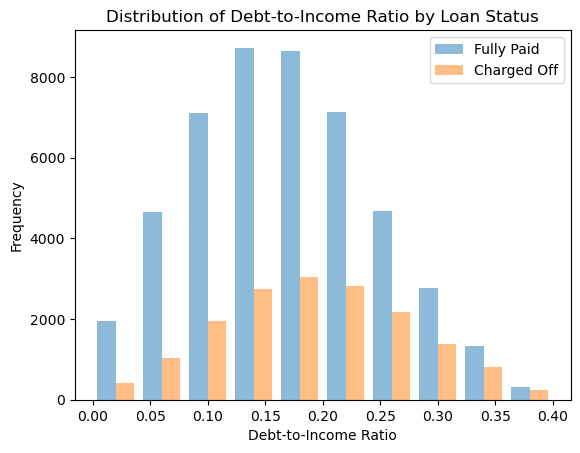

In [154]:
#Plot a histogrm of Debt to Income Ratio by Loan Status
grouped_data = df.groupby('Loan Status')['Debt to Income Ratio']

# Create a histogram for each group
plt.hist([grouped_data.get_group(status) for status in df['Loan Status'].unique()],
         bins=10, alpha=0.5, label=df['Loan Status'].unique())

# Adding labels and title
plt.xlabel('Debt-to-Income Ratio')
plt.ylabel('Frequency')
plt.title('Distribution of Debt-to-Income Ratio by Loan Status')

# Adding legend
plt.legend()

# Show the plot
plt.show()

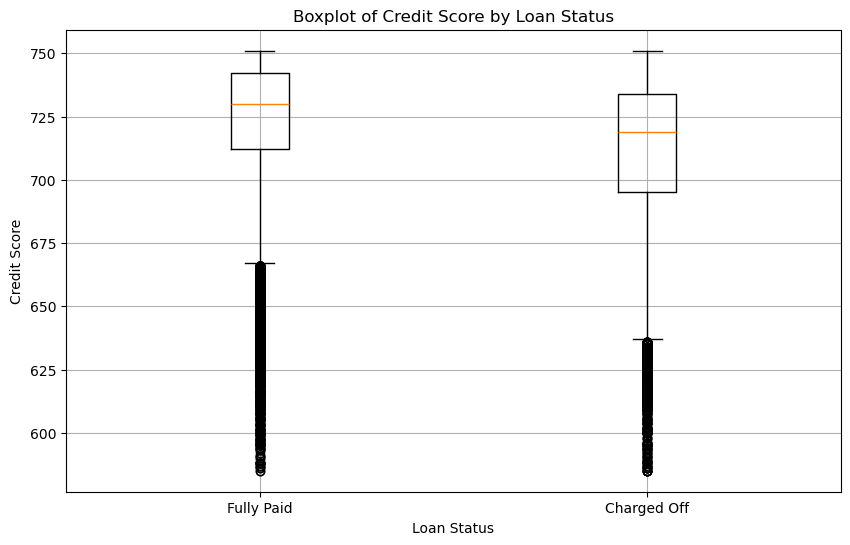

In [155]:
# Filter data by loan status
charged_off_data = df[df['Loan Status'] == 'Charged Off']
paid_off_data = df[df['Loan Status'] == 'Fully Paid']

# Create a boxplot of credit score by loan status
plt.figure(figsize=(10, 6))
plt.boxplot([paid_off_data['Credit Score'],charged_off_data['Credit Score']], labels=['Fully Paid','Charged Off'])
plt.title('Boxplot of Credit Score by Loan Status')
plt.xlabel('Loan Status')
plt.ylabel('Credit Score')
plt.grid(True)
plt.show()

In [156]:
#Metrics of Credit Scores 
df_creditscores = pd.DataFrame({'Fully Paid': paid_off_data['Credit Score'].describe(),
                    'Charged Off': charged_off_data['Credit Score'].describe()})

df_creditscores = df_creditscores.astype(float).round(1)
df_creditscores

,Fully Paid,Charged Off
count,47298.0,16618.0
mean,722.8,710.5
std,25.7,31.1
min,585.0,585.0
25%,712.0,695.0
50%,730.0,719.0
75%,742.0,734.0
max,751.0,751.0


In [157]:
df.select_dtypes(include=['float64', 'int64'])

,Current Loan Amount,Years of Credit History,Months since last delinquent,Number of Open Accounts,Number of Credit Problems,Current Credit Balance,Maximum Open Credit,Bankruptcies,Tax Liens,Debt to Income Ratio
0,445412.0,17.2,0.0,6.0,1.0,228190.0,416746.0,1.0,0.0,0.0536
2,99999999.0,14.9,29.0,18.0,1.0,297996.0,750090.0,0.0,0.0,0.1570
3,347666.0,12.0,0.0,9.0,0.0,256329.0,386958.0,0.0,0.0,0.1300
5,206602.0,17.3,0.0,6.0,0.0,215308.0,272448.0,0.0,0.0,0.2190
6,217646.0,19.6,10.0,13.0,1.0,122170.0,272052.0,1.0,0.0,0.1100
...,...,...,...,...,...,...,...,...,...,...
99994,210584.0,17.4,18.0,6.0,0.0,456.0,259160.0,0.0,0.0,0.0571
99996,99999999.0,9.4,21.0,22.0,0.0,153045.0,509234.0,0.0,0.0,0.1220
99997,103136.0,18.8,18.0,12.0,1.0,109554.0,537548.0,1.0,0.0,0.0763
99998,530332.0,15.0,0.0,8.0,0.0,404225.0,738254.0,0.0,0.0,0.0691


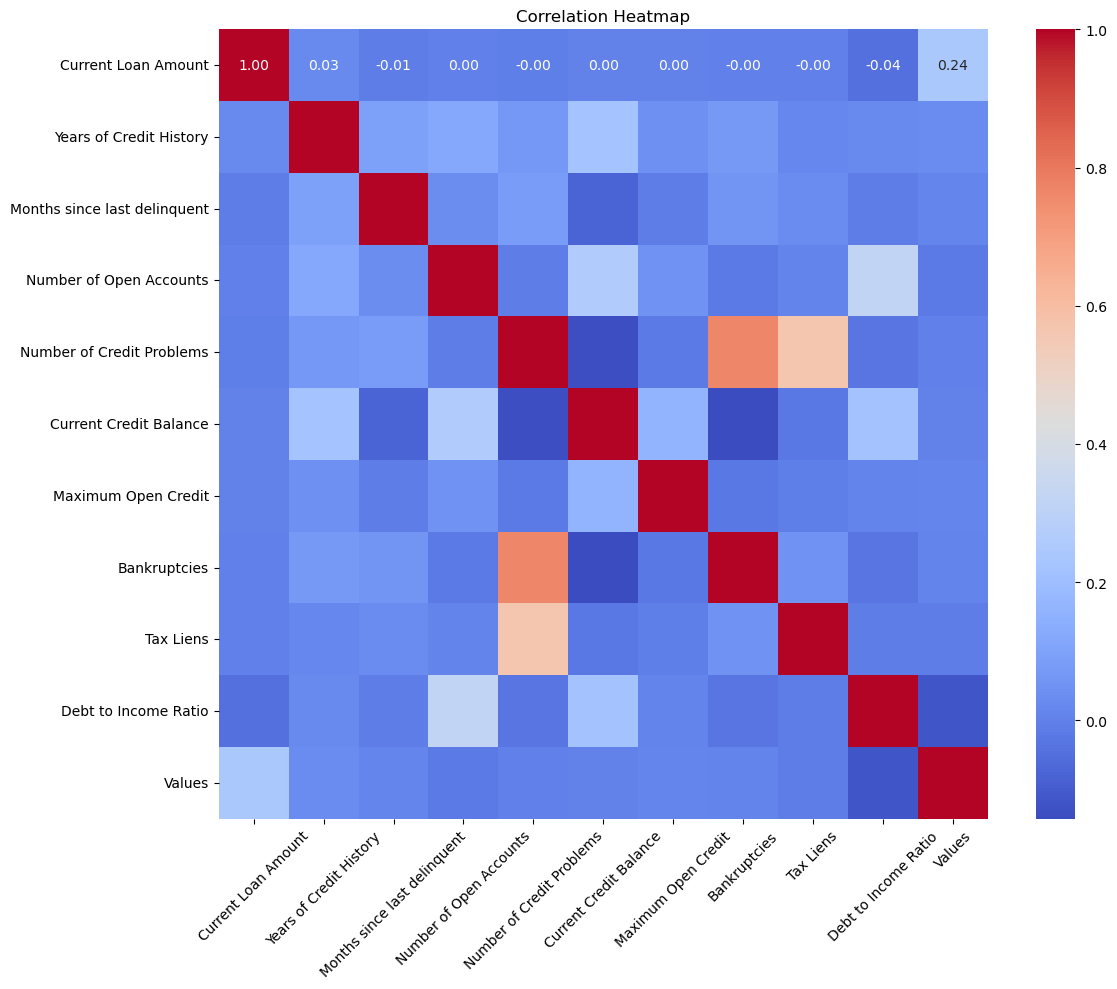

In [158]:
# Calculate the correlation matrix
df['Values'] = df['Loan Status'].apply(lambda x: 1 if x == 'Fully Paid' else 0)
corr_matrix = df.select_dtypes(include=['float64', 'int64']).corr()

# Set up the matplotlib figure
plt.figure(figsize=(12, 10))

# Create the heatmap
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")

# Customize the plot
plt.title('Correlation Heatmap')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()

# Show plot
plt.show()

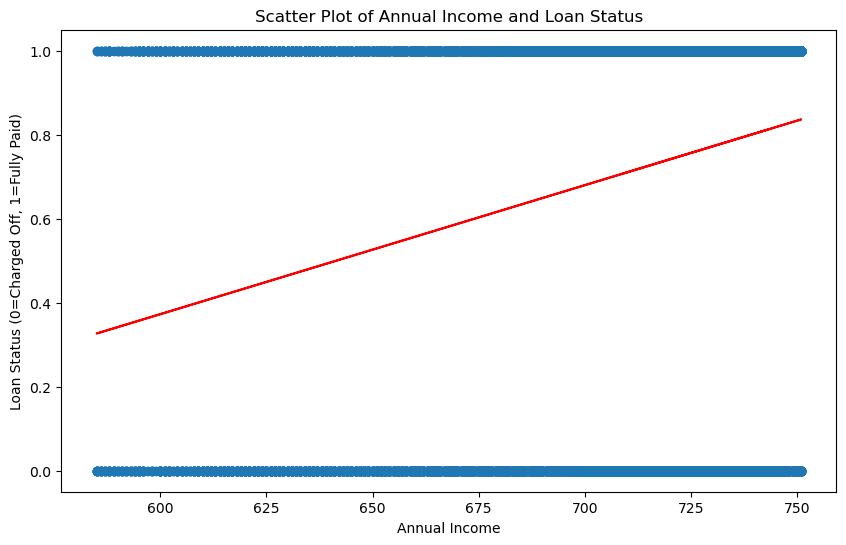

The r-value is 0.19427770335190905


In [165]:
# Extracting loan status and annual income columns
x_values = df['Credit Score']
y_values = df['Values']

# Calculating linear regression
slope, intercept, rvalue, pvalue, stderr = linregress(x_values, y_values)
regress_values = x_values * slope + intercept
line_eq = f"y = {round(slope, 4)}x + {round(intercept, 2)}"

# Creating the scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(x_values, y_values)

# Plotting the regression line
plt.plot(x_values, regress_values, "-r")

# Annotating the regression equation
plt.annotate(line_eq, (20000, 0.5), fontsize=15, color="red")

# Setting labels and title
plt.xlabel("Annual Income")
plt.ylabel("Loan Status (0=Charged Off, 1=Fully Paid)")
plt.title("Scatter Plot of Annual Income and Loan Status")
plt.ticklabel_format(style='plain', axis='x') 

# Displaying the plot
plt.show()

# Printing the correlation coefficient
print(f'The r-value is {rvalue}')

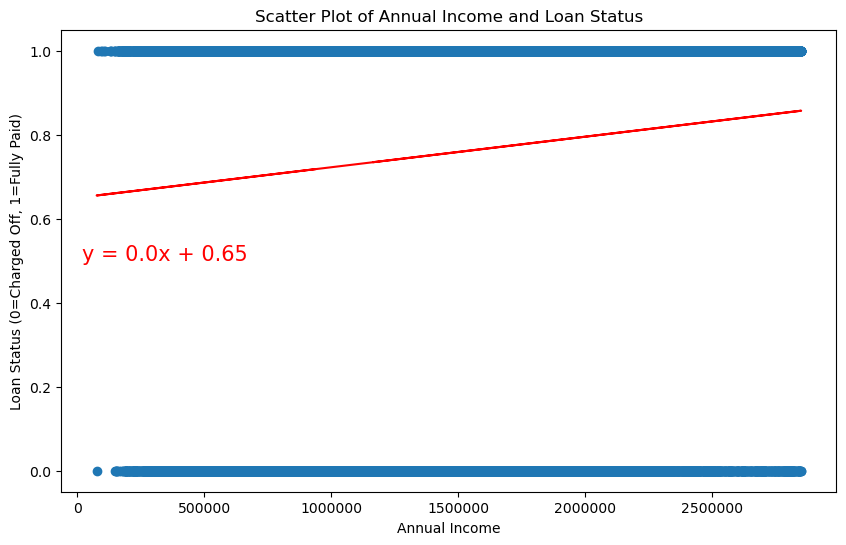

The r-value is 0.08979218286914199


In [164]:
# Extracting loan status and annual income columns
x_values = df['Annual Income']
y_values = df['Values']

# Calculating linear regression
slope, intercept, rvalue, pvalue, stderr = linregress(x_values, y_values)
regress_values = x_values * slope + intercept
line_eq = f"y = {round(slope, 4)}x + {round(intercept, 2)}"

# Creating the scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(x_values, y_values)

# Plotting the regression line
plt.plot(x_values, regress_values, "-r")

# Annotating the regression equation
plt.annotate(line_eq, (20000, 0.5), fontsize=15, color="red")

# Setting labels and title
plt.xlabel("Annual Income")
plt.ylabel("Loan Status (0=Charged Off, 1=Fully Paid)")
plt.title("Scatter Plot of Annual Income and Loan Status")
plt.ticklabel_format(style='plain', axis='x') 

# Displaying the plot
plt.show()

# Printing the correlation coefficient
print(f'The r-value is {rvalue}')

In [ ]:
# status_counts = df['Purpose'].value_counts()
# plt.bar(status_counts.index, status_counts.values, color=['green', 'red'])
# plt.xlabel('Loan Status')
# plt.ylabel('Count')
# plt.title('Distribution of Loan Status')
# plt.show()

# df_short_term = df.loc[df["Term"] == "Short Term"]
# df_long_term = df.loc[df["Term"] == "Long Term"]
# df_clean=pd.read_csv("cleaned.csv" ,sep="," ,encoding="utf-8")
# df_group = df_clean.groupby(['Term','Purpose'])
# df_group.plot(kind="bar",figsize=(10,6))
# # plt.bar(df_group)
# plt.xlabel("Term Length") 
# plt.ylabel("Number of Loans") 
# plt.title("Breakdown of Loan Reason by Term Length") 
# plt.show()




# Y_axis = df_short_term['Purpose']
# Z_axis = df_long_term['Purpose']

# X = ["Short Term","Long Term"]
# X_axis = np.arange(len(X)) 


# plt.bar(X_axis - 0.2, Y_axis, 0.4, label = 'Short Term') 
# plt.bar(X_axis + 0.2, Z_axis, 0.4, label = 'Long Term') 
  
# plt.xticks(X_axis,X) 
# plt.xlabel("Term Length") 
# plt.ylabel("Number of Loans") 
# plt.title("Breakdown of Loan Reason by Term Length") 
# plt.legend() 
# plt.show() 

The r-value is 0.19427770335190905


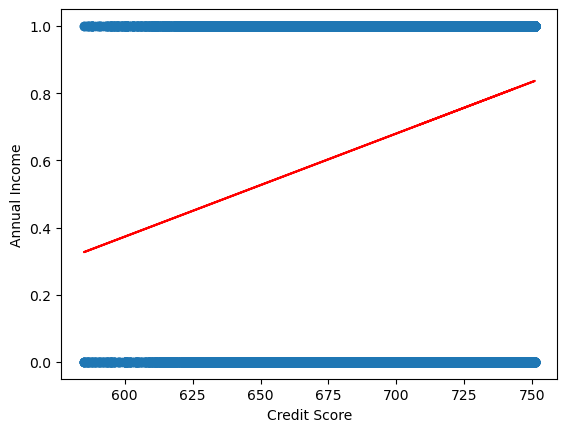

In [ ]:
df_clean=pd.read_csv("cleaned.csv")
df_clean['Purpose'].replace({'small_business': 'Business Loan'}, inplace=True)
df_clean['Purpose'].replace(['other','major_purchase','Educational Expenses',"moving",'renewable_energy','wedding'],'Other', inplace=True)
df_clean['Purpose'].replace(['Take a Trip','vacation'],'Vacation', inplace=True)
df_group = df_clean.groupby(['Term','Purpose']).size().unstack(fill_value=0)
df_group.plot(kind="bar",stacked=True,figsize=(10,6))
# plt.bar(df_group)
plt.xlabel("Term Length")
plt.ylabel("Number of Loans")
plt.title("Breakdown of Loan Reason by Term Length")
plt.tight_layout()
plt.show()

df.to_csv('cleaned.csv')

In [ ]:
cs_avg = df_clean["Credit Score"].mean() 
cs_med = df_clean["Credit Score"].median() 
cs_min = df_clean["Credit Score"].min() 
cs_max = df_clean["Credit Score"].max() 
cs_std = df_clean["Credit Score"].std()
cs_mode = df_clean["Credit Score"].mode()

df_clean["Credit Score"].describe()

#print (f"Avg: {cs_avg} Med:{cs_med} Max:{cs_max} Min:{cs_max} STD:{cs_std} Mode:{cs_mode}")

#df_clean.info()
#df['Annual Income'].value_counts()

csores = df_clean["Credit Score"]

fig1, ax1 = plt.subplots()
ax1.set_title('Temperatures at LAX')
ax1.set_ylabel('Temperature (°F)')
ax1.boxplot(csores)
plt.show()

df_clean["Credit Score"].describe()

